In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import transformers
import matplotlib as mpl
import os

os.chdir("..")

In [2]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'
# bigger size
mpl.rcParams['font.size'] = 16
# bold x-labels
mpl.rcParams['axes.labelweight'] = 'bold'
# smaller labels on axes
mpl.rcParams['axes.labelsize'] = 14

mpl.rcParams['xtick.labelsize'] = 12

## Load FLORES dataset

In [3]:
# load flores dataset for languages: en, es, pt, fr, it, ro, pl, mt, ja, zh, ko, te, ta
languages = ['en', 'es', 'pt', 'fr', 'it', 'ro', 'pl', 'mt','he', 'ar', 'ja', 'ko', 'te', 'ta', 'si']

palette = sns.color_palette("viridis", len(languages))
languages_colors = {lang: col for lang, col in zip(languages, palette)}
nice_colors = [ ]
languages_flores = {'en': 'eng_Latn',
                    'es': 'spa_Latn',
                    'pt': 'por_Latn',
                    'fr': 'fra_Latn',
                    'it': 'ita_Latn',
                    'ro': 'ron_Latn',
                    'pl': 'pol_Latn',
                    'mt': 'mlt_Latn',
                    'he': 'heb_Hebr',
                    'ar': 'arb_Arab',
                    'ja': 'jpn_Jpan',
                    #'zh': 'zho_Hans',
                    'ko': 'kor_Hang',
                    'te': 'tel_Telu',
                    'ta': 'tam_Taml',
                    #'bo': 'bod_Tibt',
                    'si': 'sin_Sinh'}
flores = {}

for lang in languages:
    with open(f'flores200_dataset/devtest/{languages_flores[lang]}.devtest', 'r') as f:
        flores[lang] = f.read().splitlines()

In [4]:
flores_chars = flores.copy()
flores_bytes = {lang: [bytes(line, 'utf-8') for line in flores[lang]] for lang in flores.keys()}
flores_words = {lang: [line.split() for line in flores[lang]] for lang in flores.keys()}


In [5]:
# XLM-R tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("xlm-roberta-base")
flores_xlmr = {lang: [tokenizer.encode(line) for line in flores[lang]] for lang in flores.keys()}

## Plot the number of tokens per language

In [6]:
def plot_token_numbers(lang_tokenized, title=None):
    token_numbers = {}
    for lang in lang_tokenized.keys():
        token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
    # sort by value
    token_numbers = dict(sorted(token_numbers.items(), key=lambda item: item[1], reverse=True))
    plt.bar(token_numbers.keys(), token_numbers.values())
    for i, lang in enumerate(token_numbers.keys()):
        plt.bar(i, token_numbers[lang], color=languages_colors[lang])
    plt.xticks(rotation=90)
    plt.ylabel("Line avg. segemnets")
    if title:
        plt.title(title)
    plt.show()

In [7]:
def plot_compare_token_numbers(lang_tokenized_methods, method_names, title=None, parity=None):
    assert len(lang_tokenized_methods) == len(method_names)
    token_number_methods = {}
    for lang_tokenized, method in zip(lang_tokenized_methods, method_names):
        token_numbers = {}
        for lang in lang_tokenized.keys():
            token_numbers[lang] = sum(len(tokenized_line) for tokenized_line in lang_tokenized[lang]) / len(lang_tokenized[lang])
        token_number_methods[method] = token_numbers

    
    token_number_methods = pd.DataFrame(token_number_methods)
    if parity and parity in token_number_methods.index:
        token_number_methods = token_number_methods / token_number_methods.loc[parity,:]
    print(token_number_methods)
    # compute mean and std
    print(f"Means: {token_number_methods.mean(axis=0)}")
    print(f"Std: {token_number_methods.std(axis=0)}")

    sns.boxplot(data=token_number_methods)
    #plt.boxplot(token_number_methods, labels=method_names)
    plt.xticks(rotation=45)
    if parity:
        plt.ylabel(f"Parity to {parity}")
    else:
        plt.ylabel("Line avg. segemnets (log)")
        plt.semilogy()
    if title:
        plt.title(title)
    plt.show()

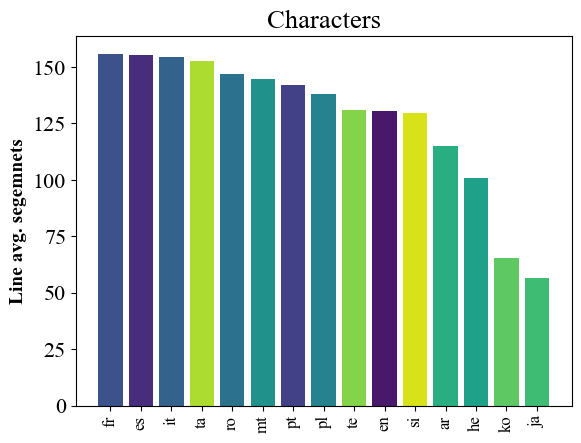

In [8]:
plot_token_numbers(flores_chars, "Characters")

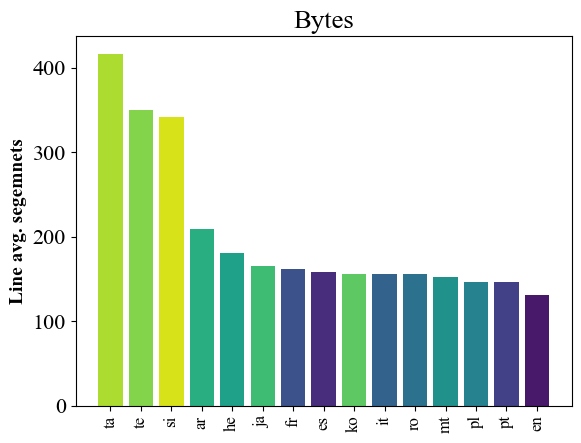

In [9]:
plot_token_numbers(flores_bytes, "Bytes")

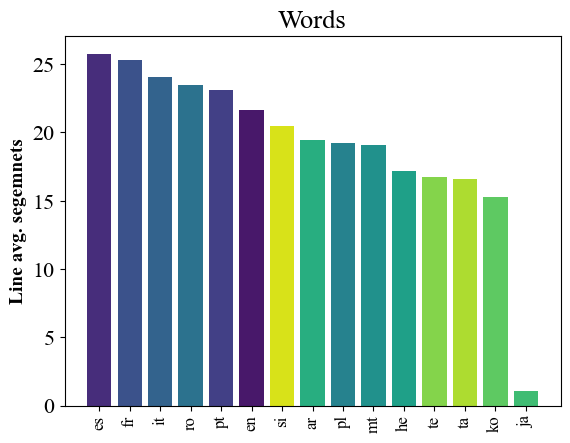

In [10]:
plot_token_numbers(flores_words, "Words")

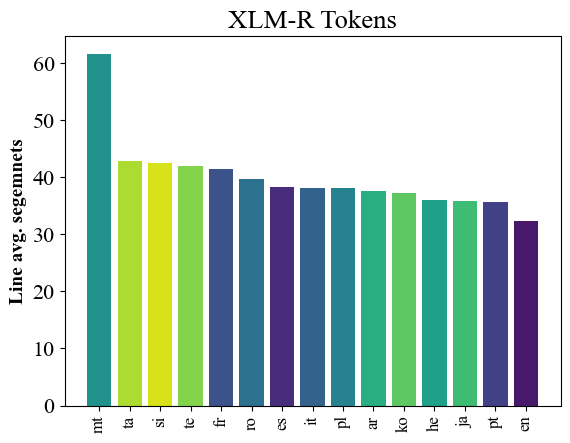

In [11]:
plot_token_numbers(flores_xlmr, "XLM-R Tokens")

## Morfessor rewriting

In [12]:
from src.rewrite_bytes import ByteRewriter
from src.utils import str_to_hex

In [13]:
decompose_file = "byte_maps/decompose.json"
morf_map_file = "byte_maps/merge_map.json"
decompose_rewriter = ByteRewriter(decompose_file)
morf_rewriter = ByteRewriter(morf_map_file)

flores_decomposed_rw = {lang: [decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' ')) for line in flores[lang]] for lang in flores.keys()}
flores_morfs_rw = {lang: [morf_rewriter.rewrite_bytes(decompose_rewriter.rewrite_bytes(str_to_hex(line).split(' '))) for line in flores[lang]] for lang in flores.keys()}

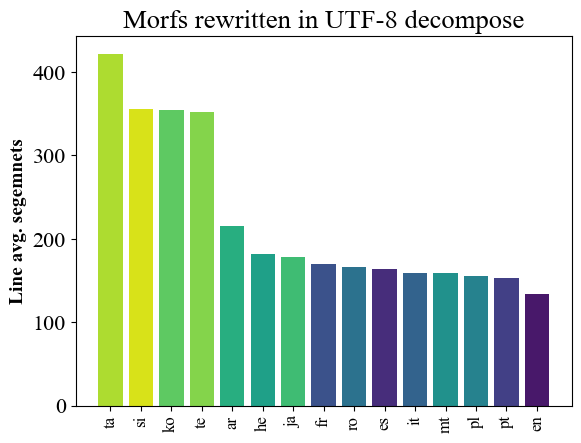

In [14]:
title = f"Morfs rewritten in UTF-8 decompose"
plot_token_numbers(flores_decomposed_rw , title)

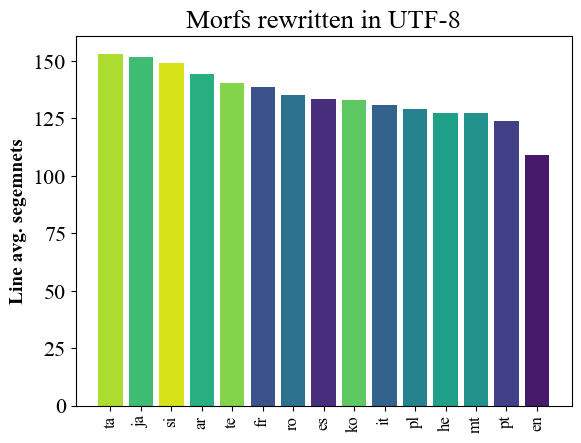

In [15]:
title = f"Morfs rewritten in UTF-8"
plot_token_numbers(flores_morfs_rw , title)

## Morfessor experiments

In [16]:
def load_morfessor_results(split, byte_patches, morf_len, morf_type_num, joint=False):
    flores_morfs = {}
    file_name= f"{split}_bp_{byte_patches}_ml_{morf_len}_mtn_{morf_type_num}"
    if joint:
        file_name = "joint_" + file_name
    for lang in languages:
        lang_fl = languages_flores[lang]
        path = f'morfessor_out/{lang_fl}/{file_name}.seg.decoded'
        try:
            with open(path, 'r') as f:
                flores_morfs[lang] = f.read().splitlines()
        except FileNotFoundError:
            print(f"File {path} not found")
            flores_morfs[lang] = [""]
    flores_morfs = {lang: [line.split() for line in flores_morfs[lang]] for lang in flores_morfs.keys()}

    return flores_morfs

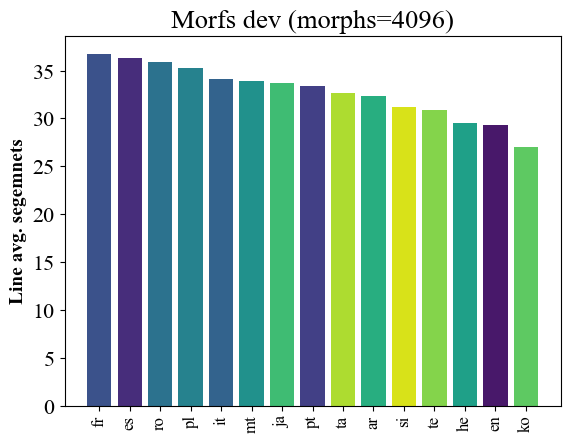

In [17]:
split = "dev"
byte_patches = 36
morf_len = 0
morf_type_num = 4096

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morfs {split} (morphs={morf_type_num})"
plot_token_numbers(flores_morfs, title)

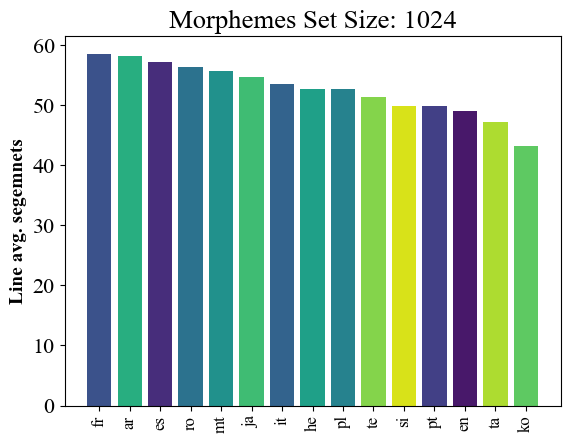

In [18]:
split = "dev"
byte_patches = 36
morf_len = 0
morf_type_num = 1024

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morphemes Set Size: {morf_type_num}"
plot_token_numbers(flores_morfs, title)

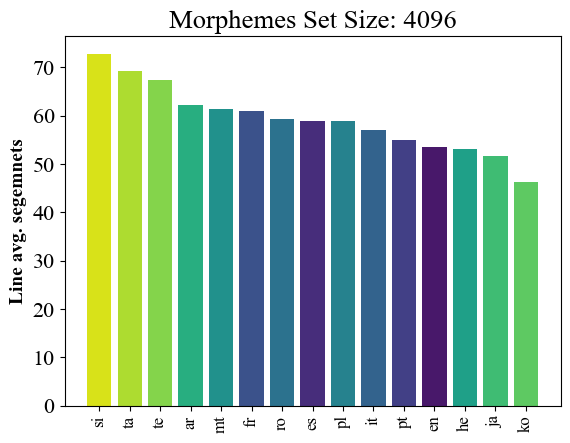

In [19]:
split = "joint_dev"
byte_patches = 24
morf_len = 0
morf_type_num = 4096

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morphemes Set Size: {morf_type_num}"
plot_token_numbers(flores_morfs, title)

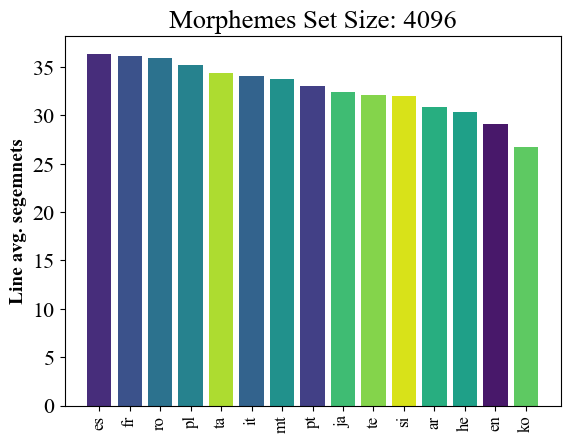

In [20]:
split = "dev"
byte_patches = 24
morf_len = 0
morf_type_num = 4096

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morphemes Set Size: {morf_type_num}"
plot_token_numbers(flores_morfs, title)

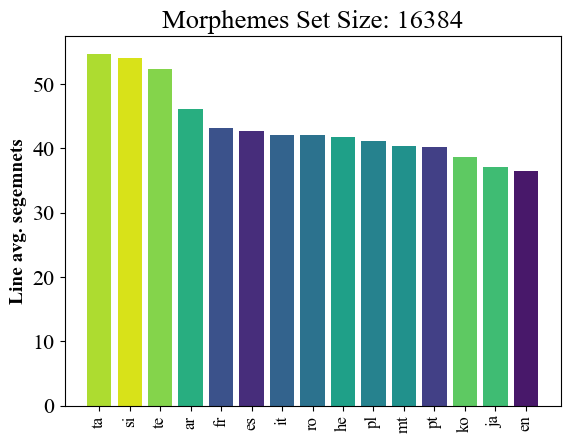

In [21]:
split = "joint_dev"
byte_patches = 24
morf_len = 0
morf_type_num = 16384

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morphemes Set Size: {morf_type_num}"
plot_token_numbers(flores_morfs, title)

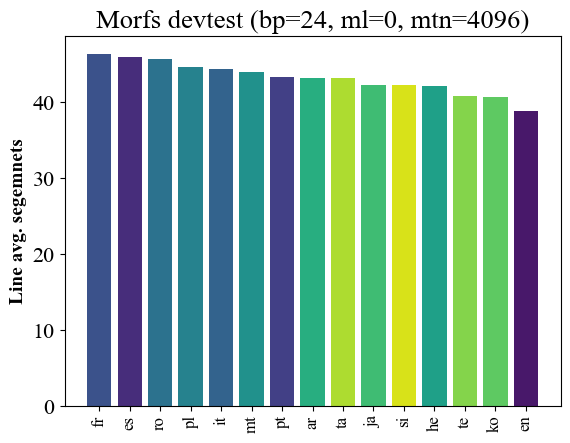

In [22]:
split = "devtest"
byte_patches = 24
morf_len = 0
morf_type_num = 4096

flores_morfs = load_morfessor_results(split, byte_patches, morf_len, morf_type_num)
title = f"Morfs {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs, title)

## Joint analysis

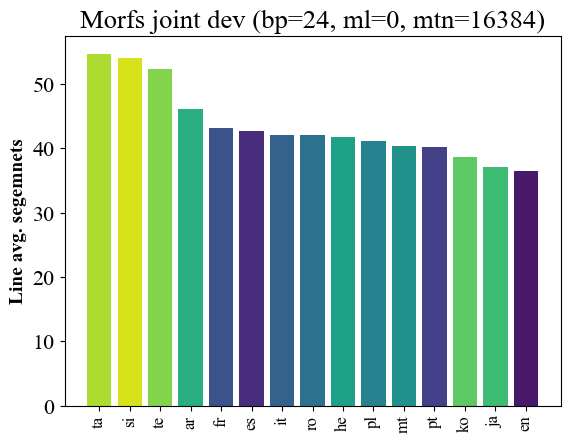

In [23]:
split = "dev"
byte_patches = 24
morf_len = 0
morf_type_num = 16384

flores_morfs_joint = load_morfessor_results(split, byte_patches, morf_len, morf_type_num, joint=True)
title = f"Morfs joint {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs_joint, title)

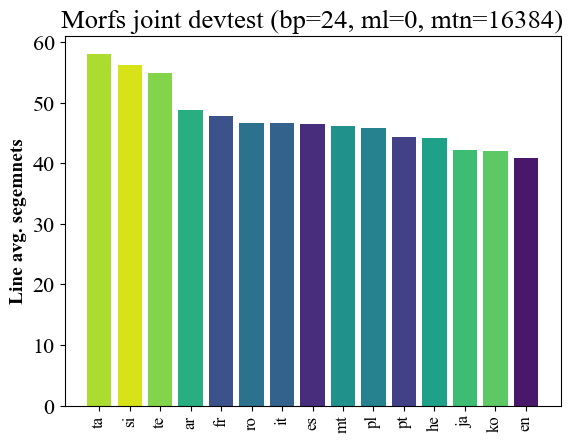

In [24]:
split = "devtest"
byte_patches = 24
morf_len = 0
morf_type_num = 16384

flores_morfs_joint = load_morfessor_results(split, byte_patches, morf_len, morf_type_num, joint=True)
title = f"Morfs joint {split} (bp={byte_patches}, ml={morf_len}, mtn={morf_type_num})"
plot_token_numbers(flores_morfs_joint, title)

## Comparision of methods 

         bytes      morfs  morfs (joint)       chars     xlmr T      words
en  130.529644  38.785573      40.904150  130.401186  32.297431  21.641304
es  158.046443  45.994071      46.559289  155.178854  38.249012  25.771739
pt  145.769763  43.349802      44.337945  141.787549  35.687747  23.135375
fr  162.081028  46.407115      47.904150  155.818182  41.433794  25.314229
it  155.394269  44.383399      46.695652  154.286561  38.121542  24.022727
ro  155.099802  45.715415      46.721344  146.844862  39.695652  23.447628
pl  146.495059  44.689723      45.884387  137.831028  38.012846  19.256917
mt  151.973320  44.011858      46.234190  144.553360  61.596838  19.046443
he  180.910079  42.152174      44.242095  100.843874  35.961462  17.162055
ar  208.770751  43.193676      48.883399  114.940711  37.540514  19.404150
ja  165.127470  42.297431      42.240119   56.267787  35.748024   1.068182
ko  155.927866  40.670949      41.998024   65.182806  37.134387  15.247036
te  349.516798  40.866601

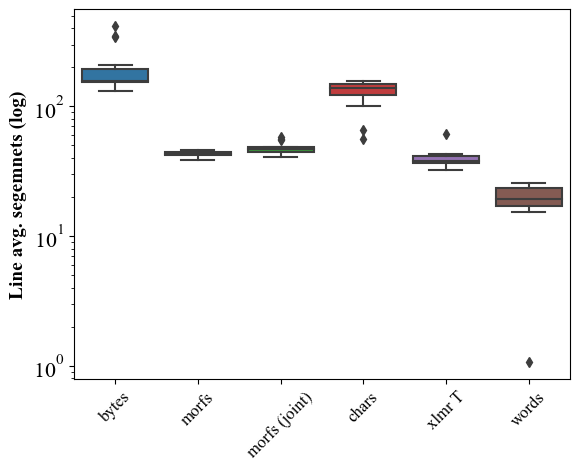

In [25]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr, flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'words'])

       bytes     morfs  morfs (joint)     chars    xlmr T     words
en  1.000000  1.000000       1.000000  1.000000  1.000000  1.000000
es  1.210809  1.185855       1.138253  1.190011  1.184274  1.190859
pt  1.116756  1.117679       1.083947  1.087318  1.104972  1.069038
fr  1.241718  1.196505       1.171132  1.194914  1.282882  1.169718
it  1.190490  1.144328       1.141587  1.183168  1.180327  1.110041
ro  1.188234  1.178671       1.142215  1.126101  1.229065  1.083467
pl  1.122313  1.152225       1.121754  1.056977  1.176962  0.889822
mt  1.164282  1.134748       1.130306  1.108528  1.907175  0.880097
he  1.385969  1.086800       1.081604  0.773336  1.113447  0.793023
ar  1.599413  1.113653       1.195072  0.881439  1.162337  0.896626
ja  1.265057  1.090545       1.032661  0.431498  1.106838  0.049358
ko  1.194578  1.048610       1.026742  0.499864  1.149763  0.704534
te  2.677681  1.053655       1.341491  1.004084  1.297262  0.773389
ta  3.191929  1.112711       1.421548  1.167975 

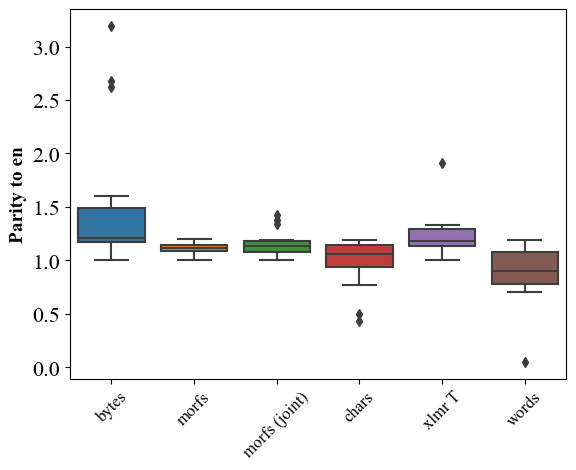

In [26]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr,  flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'words'], parity='en')

## Comparision of methods 

In [ ]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr, flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'words'])

In [ ]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr,  flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'words'], parity='en')

## Comparision of methods 

         bytes      morfs  morfs (joint)       chars     xlmr T      words
en  130.529644  38.785573      40.904150  130.401186  32.297431  21.641304
es  158.046443  45.994071      46.559289  155.178854  38.249012  25.771739
pt  145.769763  43.349802      44.337945  141.787549  35.687747  23.135375
fr  162.081028  46.407115      47.904150  155.818182  41.433794  25.314229
it  155.394269  44.383399      46.695652  154.286561  38.121542  24.022727
ro  155.099802  45.715415      46.721344  146.844862  39.695652  23.447628
pl  146.495059  44.689723      45.884387  137.831028  38.012846  19.256917
mt  151.973320  44.011858      46.234190  144.553360  61.596838  19.046443
he  180.910079  42.152174      44.242095  100.843874  35.961462  17.162055
ar  208.770751  43.193676      48.883399  114.940711  37.540514  19.404150
ja  165.127470  42.297431      42.240119   56.267787  35.748024   1.068182
ko  155.927866  40.670949      41.998024   65.182806  37.134387  15.247036
te  349.516798  40.866601

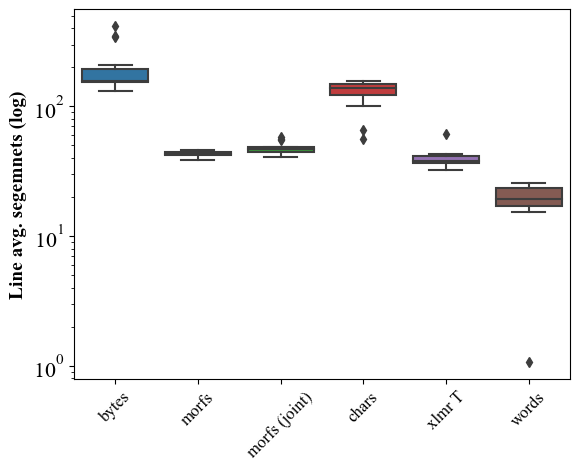

In [27]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr, flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'words'])

       bytes     morfs  morfs (joint)     chars    xlmr T     words
en  1.000000  1.000000       1.000000  1.000000  1.000000  1.000000
es  1.210809  1.185855       1.138253  1.190011  1.184274  1.190859
pt  1.116756  1.117679       1.083947  1.087318  1.104972  1.069038
fr  1.241718  1.196505       1.171132  1.194914  1.282882  1.169718
it  1.190490  1.144328       1.141587  1.183168  1.180327  1.110041
ro  1.188234  1.178671       1.142215  1.126101  1.229065  1.083467
pl  1.122313  1.152225       1.121754  1.056977  1.176962  0.889822
mt  1.164282  1.134748       1.130306  1.108528  1.907175  0.880097
he  1.385969  1.086800       1.081604  0.773336  1.113447  0.793023
ar  1.599413  1.113653       1.195072  0.881439  1.162337  0.896626
ja  1.265057  1.090545       1.032661  0.431498  1.106838  0.049358
ko  1.194578  1.048610       1.026742  0.499864  1.149763  0.704534
te  2.677681  1.053655       1.341491  1.004084  1.297262  0.773389
ta  3.191929  1.112711       1.421548  1.167975 

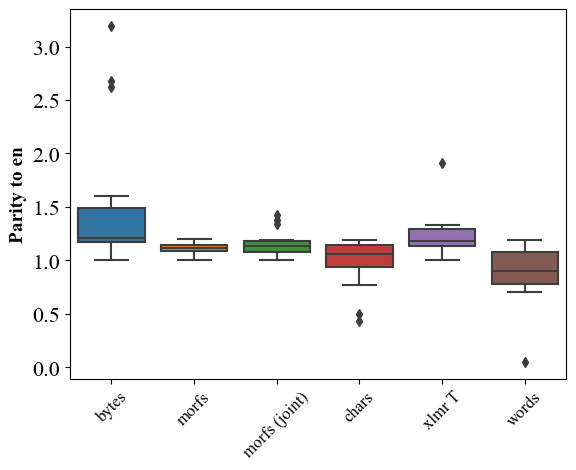

In [28]:
plot_compare_token_numbers([flores_bytes, flores_morfs, flores_morfs_joint, flores_chars, flores_xlmr,  flores_words] ,
                           ['bytes','morfs','morfs (joint)', 'chars', 'xlmr T', 'words'], parity='en')